# 1.Setup


In [0]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    

In [0]:
!pip install transformers

#2.Loading Dataset

In [0]:
local_file = "reviews_Apps_for_Android_5.json.gz"
!curl -o  $local_file https://storage.googleapis.com/tad2018/reviews_Apps_for_Android_5.json.gz

In [0]:
import gzip
import json
import pandas as pd

review_list = list()


# Construct a dataframe, by opening the JSON file line-by-line
with gzip.open(local_file) as jsonfile:
  for i, line in enumerate(jsonfile):
    # if (i >= 200000): break
    review = json.loads(line)
    review_list.append( (review['asin'], review['reviewerID'], review['reviewText'], review['summary'], review['overall']))
                   
print("We have %d reviews in our dataset"  % len(review_list))

collabels = ['productId', 'reviewerID', 'reviewText', 'summary', 'overall']
reviews = pd.DataFrame(review_list, columns=collabels)

In [221]:
reviews = reviews.sample(frac=1)
reviews_test = reviews.iloc[200000:210000,:]
reviews = reviews.iloc[:200000,:]
print('Number of training sentences: {:,}\n'.format(reviews.shape[0]))
reviews 

Number of training sentences: 200,000



,productId,reviewerID,reviewText,summary,overall,Class
613667,B00DJFIMW6,A1J5YBG20N0NNS,This game is similar to subway surfing but has...,it's despicable fun,4.0,1
273579,B007VT9J7I,A2MQP8DWPRAHBY,amazon I really want real instagram on kindle ...,I want REAL instagram,1.0,0
373777,B008XG1X18,A3AFDMQ5EXCFXA,I check to see what others have posted but hav...,Voyeur,5.0,1
375845,B008Y0REKC,A8EF5SGLBTKZ6,fairly. fun app simplistic graphics but still ...,nice,5.0,1
421612,B009LGKCS4,A3CV3J93ZYGMHJ,I was Surprised! This game slowly grabbed me....,Suprising! Engagi&ntilde;g! Revalatory!,5.0,1
...,...,...,...,...,...,...
358508,B008N8IV2U,A1FZZFSMPHCL6V,I wish this game was much better. hopefully it...,lots of flaws,1.0,0
307562,B00873IYSM,A1DZ3390V6WF7P,It is great for a quick reference on food subs...,"I do like it, but....",3.0,0
381589,B008YN460U,AP3T35P4NL9OE,this is a very cute game but this is only a de...,cute game except...,3.0,0
68110,B004WG5HP6,A3SN5EX1F3VHMV,Definitely seems like a spam app to me. Just s...,Fake.,1.0,0


In [0]:
def create_label(x):
    if x > 3:
        return 1 
    return 0 
  
reviews['Class'] = reviews.overall.apply(create_label)
reviews_test['Class'] = reviews_test.overall.apply(create_label)

In [0]:

sentences = reviews.reviewText.values
labels = reviews.Class.values


# 3.Tokenization & Input Formatting

In [220]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [219]:
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

 Original:  The app itself is good. Although if your looking to be told the truth fox isn't going to give you that. Don't believe anything you hear on any major news station.
Tokenized:  ['the', 'app', 'itself', 'is', 'good', '.', 'although', 'if', 'your', 'looking', 'to', 'be', 'told', 'the', 'truth', 'fox', 'isn', "'", 't', 'going', 'to', 'give', 'you', 'that', '.', 'don', "'", 't', 'believe', 'anything', 'you', 'hear', 'on', 'any', 'major', 'news', 'station', '.']


In [218]:
from tqdm import tqdm
input_ids = []
# input_ids_LR = []

# For every sentence...
for sent in tqdm(sentences):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

    # encoded_sent_LR = tokenizer.encode(
    #                 sent,                      # Sentence to encode.
    #                 add_special_tokens = False, # Add '[CLS]' and '[SEP]'

    #                 # This function also supports truncation and conversion
    #                 # to pytorch tensors, but we need to do padding, so we
    #                 # can't use these features :( .
    #                 # max_length = 128,          # Truncate all sentences.
    #                 #return_tensors = 'pt',     # Return pytorch tensors.
    #             )
    # input_ids_LR.append(encoded_sent_LR)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

  1%|          | 2127/200000 [00:01<02:47, 1177.98it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (660 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors
  3%|▎         | 5397/200000 [00:04<02:43, 1187.70it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (553 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (885 > 512). Running this sequence through the model will result in indexing errors
  7%|▋         | 14521/200000 [00:12<02:48, 1102.12it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 5

Original:  The app itself is good. Although if your looking to be told the truth fox isn't going to give you that. Don't believe anything you hear on any major news station.
Token IDs: [101, 1996, 10439, 2993, 2003, 2204, 1012, 2348, 2065, 2115, 2559, 2000, 2022, 2409, 1996, 3606, 4419, 3475, 1005, 1056, 2183, 2000, 2507, 2017, 2008, 1012, 2123, 1005, 1056, 2903, 2505, 2017, 2963, 2006, 2151, 2350, 2739, 2276, 1012, 102]


In [217]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))
# print('Avg sentence length: ', int(np.mean([len(sen) for sen in input_ids_LR])))


Max sentence length:  128


In [216]:
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 128
MEAN_LEN = 52

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

# input_ids_LR = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
#                           value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 128 values...

Padding token: "[PAD]", ID: 0

Done.


In [0]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in tqdm(input_ids):
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [0]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#4.Train Classification Model

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

In [0]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os


# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/My Drive/model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


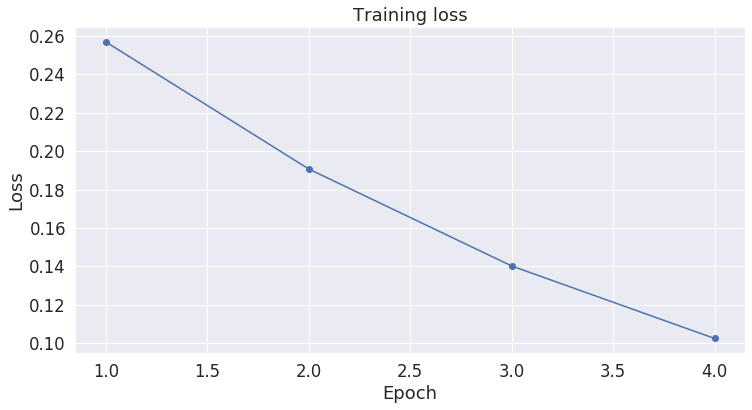

In [215]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot([1,2,3,4],loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

#5.Test

In [0]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

In [214]:

reviews_test

,productId,reviewerID,reviewText,summary,overall,Class
59635,B004UID2LC,A2XAA0ZVUTY5WQ,I really like FREEdi YouTube Downloader becaus...,A very useful app,4.0,1
227297,B007C73I58,A2378EDO1F27II,got what I expected with no invasive permissio...,good seasonal game on kfire,5.0,1
73476,B004YKVMZ4,A38PWLS2QZ3A9T,This app was very informative and I used it al...,Informative,5.0,1
131177,B0062AX2DE,A1600D0XX155NP,I am very happy with this App. It works great...,Great way teach yourself Tarot,5.0,1
232802,B007GB20UY,A3GL6M5WSI7W6S,Menus change with no input. I appear to win ra...,Buggy on Kindle Fire,2.0,0
...,...,...,...,...,...,...
595142,B00CZCX2S8,AVTY49Z9Q7DED,If you like monopoly and bingo well you just c...,fun fun fun,5.0,1
429521,B009S7IL16,ARR297M3BQTV1,Love love love this game!!! its so fun and add...,YES,5.0,1
146437,B0064X7B4A,A1OUTYTVGZM5D0,"Not fun, but the pass and play is ok. They nee...",Boring,1.0,0
309969,B0087SGWI6,A3MIAI8A8D40IG,This group of workout puzzles for the mind wil...,Good Workout,4.0,1


In [0]:
import pandas as pd


# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(reviews_test.shape[0]))

# Create sentence and label lists
sentences_test = reviews_test.reviewText.values
labels_test = reviews_test.Class.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_test = []
# input_ids_test_LR = []

# For every sentence...
for sent in sentences_test:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids_test.append(encoded_sent)
    
    # encoded_sent_LR = tokenizer.encode(
    #                 sent,                      # Sentence to encode.
    #                 add_special_tokens = False, # Add '[CLS]' and '[SEP]'
    #             )
    
    # input_ids_test_LR.append(encoded_sent_LR)

# Pad our input tokens
# input_ids_test_LR = pad_sequences(input_ids_test_LR, maxlen=128, 
#                           dtype="long", truncating="post", padding="post")

input_ids_test = pad_sequences(input_ids_test, maxlen=128, 
                          dtype="long", truncating="post", padding="post")



# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids_test:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids_test)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels_test)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [213]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 10,000 test sentences...
    DONE.


In [212]:
print('Positive samples: %d of %d (%.2f%%)' % (reviews_test.Class.sum(), len(reviews_test.Class), (reviews_test.Class.sum() / len(reviews_test.Class) * 100.0)))

Positive samples: 7285 of 10000 (72.85%)


In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary(description, predictions, true_labels):
  print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels)
  recall = recall_score(predictions, true_labels)
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1) #1 means f_1 measure
  print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  print(classification_report(predictions, true_labels, digits=3))
  print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions)) # Note the order here is true, predicted

In [211]:
pred_labels = list()

for i in range(len(true_labels)):
  pred_labels.append(np.argmax(predictions[i], axis=1).flatten())
  # a.append(pred_labels[i])
  # b.append(true_labels[i])
  if(i == 0):
    a = pred_labels[0]
    b = true_labels[0]
  if(i > 0):
    a = np.append(a,pred_labels[i])
    b = np.append(b,true_labels[i])

evaluation_summary("BERT",  a, b)

Evaluation for: BERT
Classifier 'BERT' has Acc=0.930 P=0.957 R=0.946 F1=0.952
              precision    recall  f1-score   support

           0      0.858     0.884     0.871      2680
           1      0.957     0.946     0.952      7320

    accuracy                          0.930     10000
   macro avg      0.907     0.915     0.911     10000
weighted avg      0.930     0.930     0.930     10000


Confusion matrix:
 [[2368  392]
 [ 312 6928]]


# Logistic Regression

In [0]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

#@Tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

#@Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens
  return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

one_hot_vectorizer = CountVectorizer(tokenizer=tokenize_normalize, binary=True)
input_ids_LR = one_hot_vectorizer.fit_transform(reviews['reviewText'])
input_ids_test_LR = one_hot_vectorizer.transform(reviews_test['reviewText'])

In [210]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver = 'saga')
lr.fit(input_ids_LR, labels)

evaluation_summary("LR", lr.predict(input_ids_test_LR), labels_test)



Evaluation for: LR
Classifier 'LR' has Acc=0.865 P=0.929 R=0.891 F1=0.910
              precision    recall  f1-score   support

           0      0.696     0.784     0.737      2409
           1      0.929     0.891     0.910      7591

    accuracy                          0.865     10000
   macro avg      0.812     0.838     0.823     10000
weighted avg      0.873     0.865     0.868     10000


Confusion matrix:
 [[1889  826]
 [ 520 6765]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
